In [5]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split

# Load and aggregate to daily sales
online_retail = fetch_ucirepo(id=352)
df = pd.concat([online_retail.data.features, online_retail.data.targets], axis=1)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
daily_df = df.groupby(df['InvoiceDate'].dt.date).agg({'Quantity': 'sum', 'UnitPrice': 'mean'}).reset_index()

# Feature engineering
daily_df['InvoiceDate'] = pd.to_datetime(daily_df['InvoiceDate'])
daily_df['day_of_week'] = daily_df['InvoiceDate'].dt.dayofweek
daily_df['month'] = daily_df['InvoiceDate'].dt.month

# Create 'Promo' proxy for Chapter 8 examples (1 for weekends, 0 for weekdays)
daily_df['Promo'] = (daily_df['day_of_week'] >= 5).astype(int)

# Define target and features
y = daily_df['Quantity']
X = daily_df[['day_of_week', 'month', 'UnitPrice', 'Promo']]

# 60/20/20 split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.4, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [6]:
daily_df

,InvoiceDate,Quantity,UnitPrice,day_of_week,month,Promo
0,2010-12-01,26814,4.151947,2,12,0
1,2010-12-02,21023,3.231712,3,12,0
2,2010-12-03,14830,5.047271,4,12,0
3,2010-12-05,16395,2.896576,6,12,1
4,2010-12-06,21419,4.558736,0,12,0
...,...,...,...,...,...,...
300,2011-12-05,44119,10.728895,0,12,0
301,2011-12-06,29026,3.080131,1,12,0
302,2011-12-07,39612,3.711727,2,12,0
303,2011-12-08,34460,4.414595,3,12,0


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 183, number of used features: 4
[LightGBM] [Info] Start training from score 17774.245902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

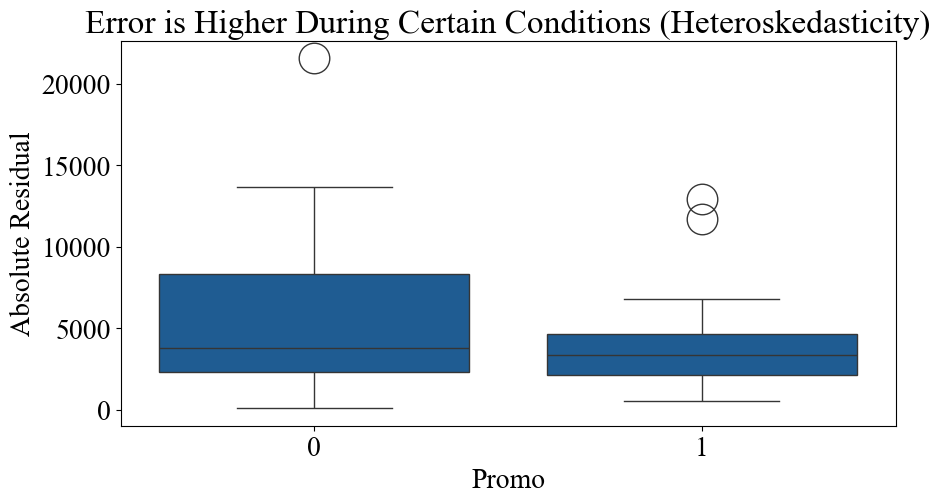

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from mapie.regression import ConformalizedQuantileRegressor
from mapie.metrics.regression import regression_coverage_score

def diagnose_heteroskedasticity(y_test, y_pred, feature_series):
    """Visualize uneven variance to justify the transition to CQR."""
    residuals_abs = np.abs(y_test - y_pred)
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=feature_series, y=residuals_abs)
    plt.title("Error is Higher During Certain Conditions (Heteroskedasticity)")
    plt.ylabel("Absolute Residual")
    plt.show()

# Train baseline LGBMRegressor to generate point forecasts for diagnosis
model_fixed = LGBMRegressor(n_estimators=100, max_depth=5, random_state=42)
model_fixed.fit(X_train, y_train)

# Generate predictions to define 'y_pred_fixed'
y_pred_fixed = model_fixed.predict(X_test)

# Diagnose why we need CQR (assuming X_test has a 'Promo' feature)
diagnose_heteroskedasticity(y_test, y_pred_fixed, X_test['Promo'])

In [18]:
def train_cqr_model(X_train, y_train, X_calib, y_calib, alpha=0.1):
    """Train CQR by manually fitting models to bypass parameter detection issues."""
    quantiles = [alpha / 2, 1 - (alpha / 2), 0.5]  # [0.05, 0.95, 0.5]
    estimators = []
    
    for q in quantiles:
        model = LGBMRegressor(objective="quantile", alpha=q, random_state=42)
        model.fit(X_train, y_train)
        estimators.append(model)
        
    # The order must be: [lower_quantile, upper_quantile, median]
    cqr = ConformalizedQuantileRegressor(
        estimator=estimators, 
        confidence_level=1 - alpha,
        prefit=True
    )
    
    cqr.conformalize(X_calib, y_calib)
    
    return cqr
    
# Fit adaptive model
cqr_model = train_cqr_model(X_train, y_train, X_calib, y_calib, alpha=0.1)

# Generate adaptive intervals
# Use predict_interval (alpha is defined in the constructor)
y_pred_cqr, y_pis_cqr = cqr_model.predict_interval(X_test)

# Extract 1D bounds: (n_samples, 2, 1) -> (n_samples,)
y_low_cqr = y_pis_cqr[:, 0, 0]
y_high_cqr = y_pis_cqr[:, 1, 0]

# Evaluate conditional coverage (e.g., checking only Promotion days)
promo_mask = (X_test['Promo'] == 1)
cqr_coverage = regression_coverage_score(
    y_test[promo_mask], y_pis_cqr[promo_mask]
)[0]

print(f"CQR Coverage on Promotion Days: {cqr_coverage:.2%}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 183, number of used features: 4
[LightGBM] [Info] Start training from score 5650.400391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

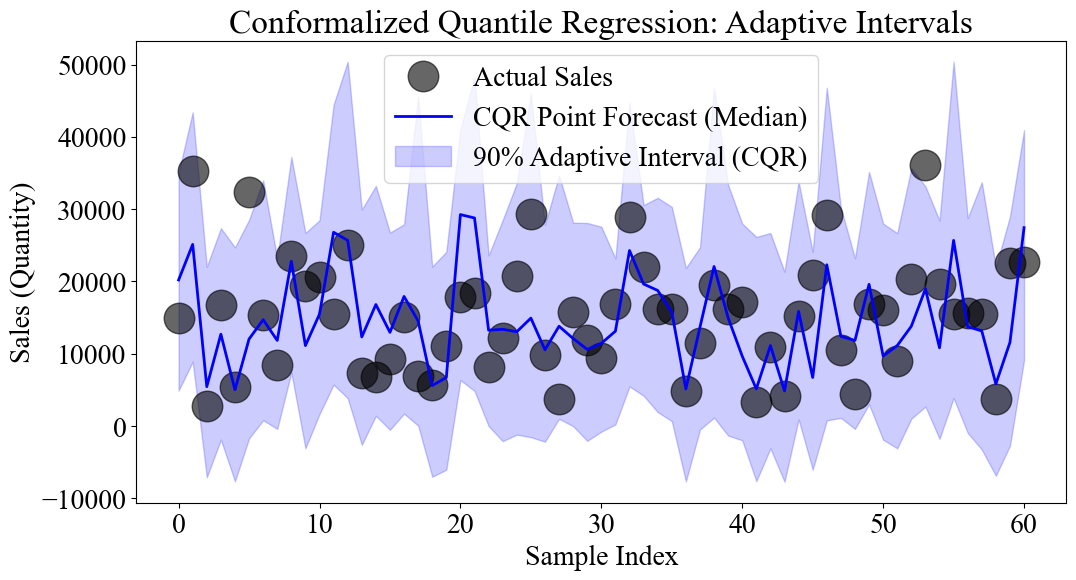

In [19]:
def plot_adaptive_results(y_true, y_pred, y_low, y_high, n_points=100):
    """Visualize point forecasts and adaptive CQR intervals."""
    # Ensure n_points does not exceed the available test data length
    n_points = min(len(y_true), n_points)
    indices = np.arange(n_points)
    
    plt.figure(figsize=(12, 6))
    
    # Plot ground truth and point forecasts
    plt.plot(indices, y_true[:n_points], "ko", label="Actual Sales", alpha=0.6)
    plt.plot(indices, y_pred[:n_points], "b-", label="CQR Point Forecast (Median)")
    
    # Plot adaptive intervals
    # .ravel() ensures the arrays are 1D for fill_between
    plt.fill_between(
        indices, 
        y_low[:n_points].ravel(), 
        y_high[:n_points].ravel(), 
        color="blue", 
        alpha=0.2, 
        label="90% Adaptive Interval (CQR)"
    )
    
    plt.title("Conformalized Quantile Regression: Adaptive Intervals")
    plt.xlabel("Sample Index")
    plt.ylabel("Sales (Quantity)")
    plt.legend()
    plt.show()

plot_adaptive_results(y_test, y_pred_cqr, y_low_cqr, y_high_cqr)